Goals:

Biopython: For calculating GC content, k-mer frequencies, ORFs, and more.


RepeatMasker: To find tandem or interspersed repeats.


HMMER/MEME Suite: For motif and pattern searches.


FASTA Tools: Command-line tools for sequence manipulation and statistics.


Features to target

GC/AT content


K-mer frequencies


Sequence length


Nucleotide skew


ORFs (if it's a coding sequence)


Palindromic sequences


Shannon entropy
Repeats and motifs (with computational tools)

In [1]:
!pip install biopython
!pip install SeqIO


#fasta parser

In [2]:
# # Unzip the file into a folder named 'dataset'
# !unzip -q dataset.zip -d dataset

# # Verify the contents of the 'dataset' folder
# print("Contents extracted to 'dataset':")
# !ls dataset


In [1]:
import os
from Bio import SeqIO
import pandas as pd

# Directory containing the dataset
base_dir = "dataset"

# Function to parse a single .fna file and extract sequence
def parse_fna(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

def get_header_as_list(file_path):
    with open(file_path, "r") as file:
        for line in file:
            if line.startswith(">"):  # Check if the line is a header
                return line.strip().split(" ")  # Strip newline and split by space
    return []

# Process all files in the dataset directory
data = []

for root, dirs, files in os.walk(base_dir):
    for file_name in files:
        if file_name.startswith(("axolotl")) and file_name.endswith(".fna"):  # add "zebrafish" to include or jsut use axolotl
            # Determine folder name (e.g., 'regen' or 'non-regen')
            folder_name = os.path.basename(root)
            regen_value = 1 if folder_name.lower() == "regen" else 0  # regen: 1, non-regen: 0

            # Parse file
            gene_name = file_name.replace("axolotl_", "").replace("zebrafish_", "").replace("_.fna", "")
            file_path = os.path.join(root, file_name)
            sequences = parse_fna(file_path)

            first_line = get_header_as_list(file_path)

            organism = first_line[2].split("=")[1] + " " + first_line[3].strip("]")
            gene_id = first_line[4].split("=")[1].strip("]")
            chromosome = first_line[5].split("=")[1].strip("]")

            for seq in sequences:
                data.append({"gene_name": gene_name, "sequence": seq, "organism": organism, "gene_id": gene_id, "chromosome": chromosome, "regen": regen_value})

# Convert to DataFrame
df = pd.DataFrame(data)
print(f"Processed {len(df)} sequences.")
print(df.head())

# Save as a CSV for feature engineering
df.to_csv("processed_genes.csv", index=False)


Processed 81 sequences.
  gene_name                                           sequence  \
0      FASN  CCATTGGCCGGCCGCGAGGAGGGAGCTGTCAGCCCATGTGGCGTGT...   
1      GCGR  TGGAAAGTTTCTGTGTAGTGAGAGGTGACGGCTGACTACGGGGGAT...   
2    THAP11  TGTCACCGGAAGCTGTTAGCATTGTGGGACATGTAGTTCCGGTTCG...   
3      CDK2  ACCGTTTTGGGCGGGATCTCGAGAAGGCGGGAAGCTACGGCCCTAT...   
4      ATK1  GGAGCAGGAGCAGGCAGGCAGGCCAGGCCGGAGAGCAAGGAGCCAG...   

              organism    gene_id chromosome  regen  
0  Ambystoma mexicanum  138583256         3q      0  
1  Ambystoma mexicanum  138583226         3q      0  
2  Ambystoma mexicanum  138583276         1p      0  
3  Ambystoma mexicanum  138582470         3q      0  
4  Ambystoma mexicanum  138527104         14      0  


In [2]:
df.tail(5)

,gene_name,sequence,organism,gene_id,chromosome,regen
76,PSIP1,CAGCTGGTGGCAACTATGGCGAGCGCTGCAGTCGTGTGTTTATCTC...,Ambystoma mexicanum,138510412,6p,1
77,TGFBR1,GTACAGCCAATGACCCGGGGTGAGGGGGGATGAGGGGTTCAGGATC...,Ambystoma mexicanum,138497249,5q,1
78,MARCKSL1,GCGCAGACTCTGCACGGCTTTTGCGAGAGAAGCAGCGAGAGAGACC...,Ambystoma mexicanum,138503035,11,1
79,HOXA13,GGGGGCGGGCTGCCGCGCCAGCCCCGCTAAGGCTCGGCGGAGAGGG...,Ambystoma mexicanum,138569852,2q,1
80,LMX1B,ACACTCACTCCGTGACTGTTCTCTGGGAGCCCCGCAGACCCGCCGC...,Ambystoma mexicanum,138471656,8,1


In [3]:
import pandas as pd
from collections import Counter

# Function to compute k-mer frequencies
def compute_kmer_frequencies(sequence, k=3):
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    kmer_counts = Counter(kmers)
    total_kmers = sum(kmer_counts.values())
    # Normalize counts
    kmer_frequencies = {f"kmer_{k}_{key}": val / total_kmers for key, val in kmer_counts.items()}
    return kmer_frequencies

# Function to compute GC content
def compute_gc_content(sequence):
    gc_count = sequence.count("G") + sequence.count("C")
    return gc_count / len(sequence) if len(sequence) > 0 else 0

# Function to compute AT/GC ratio
def compute_at_gc_ratio(sequence):
    at_count = sequence.count("A") + sequence.count("T")
    gc_count = sequence.count("G") + sequence.count("C")
    return at_count / gc_count if gc_count > 0 else 0

# Generate features for each sequence
features = []
for _, row in df.iterrows():
    sequence = row['sequence']
    feature_row = {
        "gene_name": row['gene_name'],
        "sequence_length": len(sequence),
        "gc_content": compute_gc_content(sequence),
        "at_gc_ratio": compute_at_gc_ratio(sequence),
    }
    # Add k-mer frequencies (e.g., k=3)
    feature_row.update(compute_kmer_frequencies(sequence, k=3))
    features.append(feature_row)

# Convert features to DataFrame
features_df = pd.DataFrame(features)

# Fill missing k-mers with zeros
features_df.fillna(0, inplace=True)

print(features_df.head())

# Save features to CSV for modeling
features_df.to_csv("gene_features.csv", index=False)


  gene_name  sequence_length  gc_content  at_gc_ratio  kmer_3_CCA  kmer_3_CAT  \
0      FASN           297582    0.482701     1.071678    0.019396    0.019470   
1      GCGR           800864    0.477238     1.095389    0.019511    0.019708   
2    THAP11             4237    0.447014     1.237064    0.012515    0.018182   
3      CDK2           185889    0.467290     1.140000    0.019883    0.017096   
4      ATK1           397239    0.473405     1.112355    0.021378    0.019444   

   kmer_3_ATT  kmer_3_TTG  kmer_3_TGG  kmer_3_GGC  ...  kmer_3_ATC  \
0    0.016305    0.017841    0.020949    0.014883  ...    0.012975   
1    0.017274    0.018671    0.021926    0.016394  ...    0.013160   
2    0.025974    0.022432    0.017946    0.014404  ...    0.009917   
3    0.018603    0.020469    0.020195    0.013336  ...    0.013879   
4    0.018002    0.020993    0.020622    0.013674  ...    0.014248   

   kmer_3_TCG  kmer_3_TCC  kmer_3_CCT  kmer_3_CTA  kmer_3_CAN  kmer_3_ANN  \
0    0.006472  

In [4]:
features_df

,gene_name,sequence_length,gc_content,at_gc_ratio,kmer_3_CCA,kmer_3_CAT,kmer_3_ATT,kmer_3_TTG,kmer_3_TGG,kmer_3_GGC,...,kmer_3_ATC,kmer_3_TCG,kmer_3_TCC,kmer_3_CCT,kmer_3_CTA,kmer_3_CAN,kmer_3_ANN,kmer_3_NNN,kmer_3_NNT,kmer_3_NTA
0,FASN,297582,0.482701,1.071678,0.019396,0.019470,0.016305,0.017841,0.020949,0.014883,...,0.012975,0.006472,0.018170,0.019887,0.011829,0.0,0.0,0.0,0.0,0.0
1,GCGR,800864,0.477238,1.095389,0.019511,0.019708,0.017274,0.018671,0.021926,0.016394,...,0.013160,0.005987,0.017196,0.019570,0.012292,0.0,0.0,0.0,0.0,0.0
2,THAP11,4237,0.447014,1.237064,0.012515,0.018182,0.025974,0.022432,0.017946,0.014404,...,0.009917,0.007792,0.012987,0.016057,0.012279,0.0,0.0,0.0,0.0,0.0
3,CDK2,185889,0.467290,1.140000,0.019883,0.017096,0.018603,0.020469,0.020195,0.013336,...,0.013879,0.007370,0.018861,0.020034,0.011588,0.0,0.0,0.0,0.0,0.0
4,ATK1,397239,0.473405,1.112355,0.021378,0.019444,0.018002,0.020993,0.020622,0.013674,...,0.014248,0.006893,0.019152,0.020761,0.012695,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,PSIP1,828776,0.483298,1.069116,0.020267,0.016432,0.016552,0.018789,0.020326,0.015537,...,0.013305,0.008930,0.019619,0.020784,0.011936,0.0,0.0,0.0,0.0,0.0
77,TGFBR1,360240,0.465784,1.146918,0.020164,0.017244,0.017735,0.019384,0.019806,0.013591,...,0.013158,0.006707,0.017747,0.019043,0.011787,0.0,0.0,0.0,0.0,0.0
78,MARCKSL1,4852,0.611088,0.636425,0.018763,0.008041,0.009691,0.022887,0.039381,0.024330,...,0.005567,0.004536,0.015670,0.020000,0.010722,0.0,0.0,0.0,0.0,0.0
79,HOXA13,2800,0.522857,0.912568,0.016798,0.013581,0.017870,0.013581,0.021801,0.022873,...,0.005004,0.012152,0.009650,0.015726,0.008220,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop gene_name and separate features and target (assuming 'associated' as target column, update as needed)
X = features_df.drop(columns=['gene_name'])
y = (features_df['gc_content'] > 0.45).astype(int)  # Example: Binary target based on gc_content threshold

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=46)


In [6]:
X_train

array([[-0.6074117 ,  0.39668895, -0.39951225, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [ 0.93166629, -0.18690009,  0.02412133, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [ 1.85739106,  0.07811159, -0.17695302, ...,  8.94427191,
         8.94427191,  8.94427191],
       ...,
       [ 0.25817972,  0.14295862, -0.22262442, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [-0.52789804,  0.76073721, -0.63577592, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [-0.15288892,  0.25572492, -0.30255266, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ]])

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping


# Adjusting CNN-LSTM for tabular data
model = Sequential([
    Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=3,             # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=50,                 # Maximum number of epochs
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)

2024-11-30 13:38:24.380651: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-30 13:38:24.384887: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-30 13:38:24.395342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732995504.413485   76420 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732995504.419477   76420 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 13:38:24.439837: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/50


/home/jeremymillford/miniconda3_ub/envs/msse-python/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
W0000 00:00:1732995506.865936   76420 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.7417 - loss: 0.6892 - val_accuracy: 0.8235 - val_loss: 0.6637
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7688 - loss: 0.6645 - val_accuracy: 0.8235 - val_loss: 0.6315
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7750 - loss: 0.6361 - val_accuracy: 0.8235 - val_loss: 0.5921
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7708 - loss: 0.6048 - val_accuracy: 0.8235 - val_loss: 0.5377
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7042 - loss: 0.6180 - val_accuracy: 0.8235 - val_loss: 0.4925
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7646 - loss: 0.5560 - val_accuracy: 0.8235 - val_loss: 0.4345
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7604 - loss: 0.5604 - val_accuracy: 0.8235 - val_loss: 0.4093
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7667 - loss: 0.5249 - val_accuracy: 0.8824 - val_loss: 0.3889
Epoch 9/50

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8824 - loss: 0.3232
Test Accuracy: 0.8824


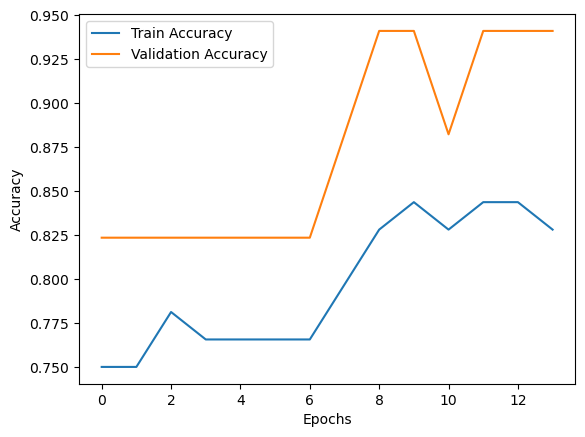

In [8]:
import matplotlib.pyplot as plt

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


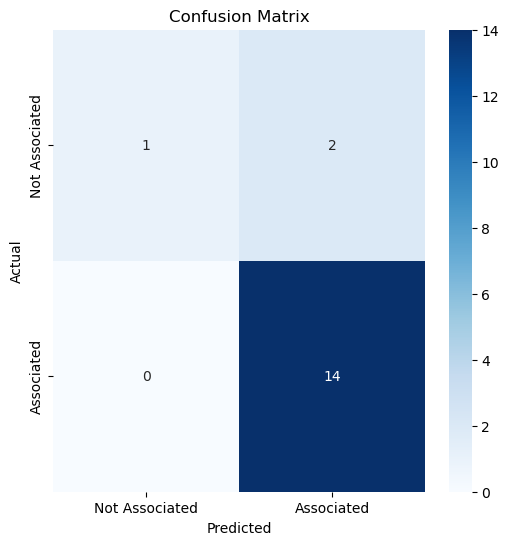

                precision    recall  f1-score   support

Not Associated       1.00      0.33      0.50         3
    Associated       0.88      1.00      0.93        14

      accuracy                           0.88        17
     macro avg       0.94      0.67      0.72        17
  weighted avg       0.90      0.88      0.86        17



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Not Associated", "Associated"]))


In [10]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


/home/jeremymillford/miniconda3_ub/envs/msse-python/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 18it [00:41,  2.99s/it]                        


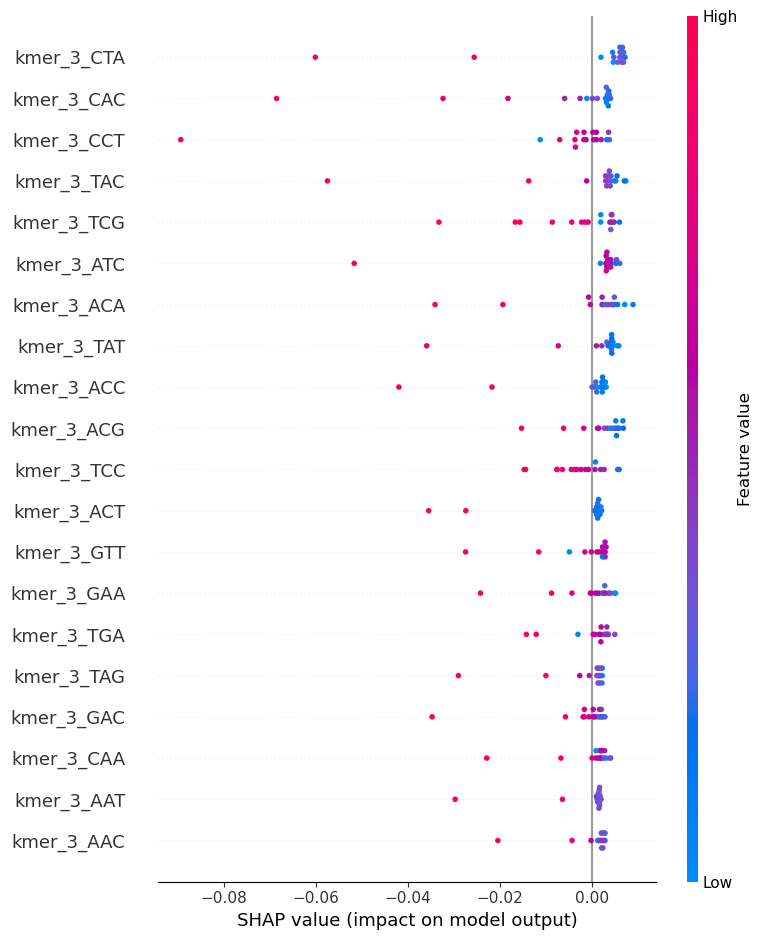

In [11]:
import shap #to show impactful features we are using

# Create SHAP explainer for your model
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Display summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


In [12]:

def parse_fasta_file(file_path):
    """Parses a FASTA file and extracts the sequences."""
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

def extract_features_from_sequences(sequences, k=3):
    """Extracts features from a list of sequences."""
    features = []
    for seq in sequences:
        if len(seq) < k:  # Skip sequences too short for k-mer analysis
            continue
        feature_row = {
            "sequence_length": len(seq),
            "gc_content": compute_gc_content(seq),
            "at_gc_ratio": compute_at_gc_ratio(seq),
        }
        feature_row.update(compute_kmer_frequencies(seq, k=k))
        features.append(feature_row)
    return pd.DataFrame(features)

# Step 4: Scale the Features
def scale_features(data_df, scaler):
    """Scales the features using the provided scaler."""
    # Reindex to ensure alignment with scaler features
    data_df = data_df.reindex(columns=scaler.feature_names_in_, fill_value=0)
    return scaler.transform(data_df)

# Step 5: Make Predictions
def predict_and_save_results(model, scaler, data_df, output_file, threshold=0.5):
    """Predicts classes using the model and saves results to a CSV file."""
    # Scale features
    scaled_data = scale_features(data_df, scaler)
    
    # Predict probabilities
    predictions = model.predict(scaled_data)
    
    # Convert probabilities to binary classes
    predicted_classes = (predictions > threshold).astype(int)
    
    # Add predictions to DataFrame
    data_df['predicted_class'] = predicted_classes
    data_df['predicted_probability'] = predictions
    
    # Save to CSV
    data_df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

# Step 6: Main Workflow
def main(fasta_file, scaler, model, output_file, k=3):
    # Parse sequences from FASTA
    sequences = parse_fasta_file(fasta_file)
    
    # Extract features
    new_data_df = extract_features_from_sequences(sequences, k=k)
    
    # Predict and save results
    predict_and_save_results(model, scaler, new_data_df, output_file)

# Run the pipeline
if __name__ == "__main__":
    fasta_file = "axolotl_cds_from_genomic.fna"  # Replace with your FASTA file path
    output_file = "cds_predictions.csv"
    
    # Use your trained scaler and model here
    # Assuming scaler and model are preloaded
    main(fasta_file, scaler, model, output_file, k=3)


1613/1613 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step
Predictions saved to cds_predictions.csv


In [18]:

# Load the predictions file
predictions_df = pd.read_csv("cds_predictions.csv")

# Inspect the first few rows
print(predictions_df.head())

# Summary of the file
print(predictions_df.info())


   sequence_length  gc_content  at_gc_ratio  kmer_3_ATG  kmer_3_TGC  \
0             1122    0.488414     1.047445    0.025000    0.024107   
1             1041    0.537944     0.858929    0.018287    0.018287   
2             1242    0.505636     0.977707    0.016935    0.022581   
3             1149    0.499565     1.001742    0.016565    0.020052   
4              777    0.518662     0.928040    0.015484    0.020645   

   kmer_3_GCC  kmer_3_CCA  kmer_3_CAA  kmer_3_AAA  kmer_3_AAG  ...  \
0    0.015179    0.023214    0.024107    0.019643    0.016964  ...   
1    0.013474    0.022137    0.013474    0.014437    0.015399  ...   
2    0.013710    0.019355    0.024194    0.018548    0.013710  ...   
3    0.011334    0.020052    0.025283    0.019180    0.013949  ...   
4    0.015484    0.021935    0.024516    0.016774    0.016774  ...   

   kmer_3_GAA  kmer_3_GCG  kmer_3_CGG  kmer_3_ACG  kmer_3_ATC  kmer_3_CGA  \
0    0.013393    0.007143    0.006250    0.007143    0.013393    0.008036  

In [19]:
# Summary statistics for numerical features
print(predictions_df.describe())

# Class distribution
print(predictions_df['predicted_class'].value_counts())


       sequence_length    gc_content   at_gc_ratio    kmer_3_ATG  \
count     51594.000000  51594.000000  51594.000000  51585.000000   
mean       2118.118890      0.495574      1.040337      0.021023   
std        2244.125994      0.052416      0.214895      0.006074   
min          96.000000      0.255952      0.278997      0.000235   
25%         960.000000      0.457953      0.886689      0.017576   
50%        1488.000000      0.493168      1.027707      0.020781   
75%        2487.000000      0.530029      1.183631      0.024181   
max      101004.000000      0.781863      2.906977      0.131767   

         kmer_3_TGC    kmer_3_GCC    kmer_3_CCA    kmer_3_CAA    kmer_3_AAA  \
count  51533.000000  51396.000000  51496.000000  51530.000000  51368.000000   
mean       0.019462      0.016213      0.022224      0.022220      0.025137   
std        0.006394      0.007438      0.007283      0.006715      0.013898   
min        0.000200      0.000240      0.000162      0.000148      0.00

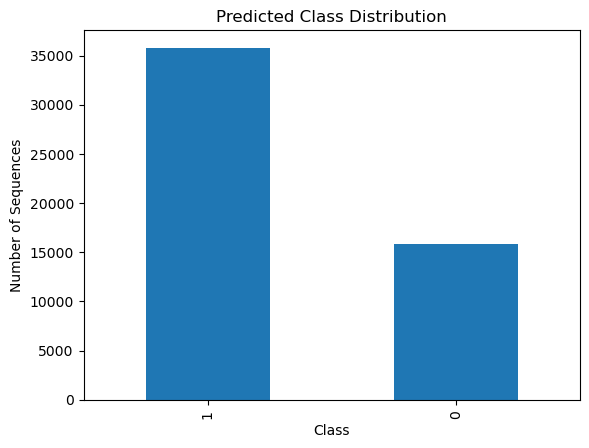

In [20]:
import matplotlib.pyplot as plt

# Plot class distribution
predictions_df['predicted_class'].value_counts().plot(kind='bar')
plt.title("Predicted Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Sequences")
plt.show()


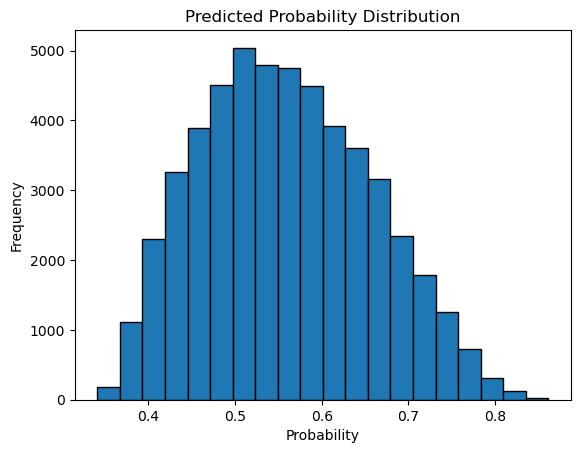

In [21]:
# Plot probability distribution
plt.hist(predictions_df['predicted_probability'], bins=20, edgecolor='k')
plt.title("Predicted Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()


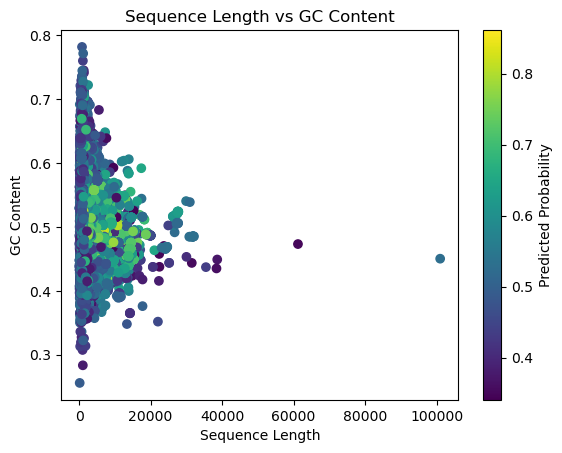

In [17]:
# Scatter plot of sequence length vs GC content, colored by predicted probability
plt.scatter(predictions_df['sequence_length'], predictions_df['gc_content'], 
            c=predictions_df['predicted_probability'], cmap='viridis')
plt.colorbar(label='Predicted Probability')
plt.title("Sequence Length vs GC Content")
plt.xlabel("Sequence Length")
plt.ylabel("GC Content")
plt.show()


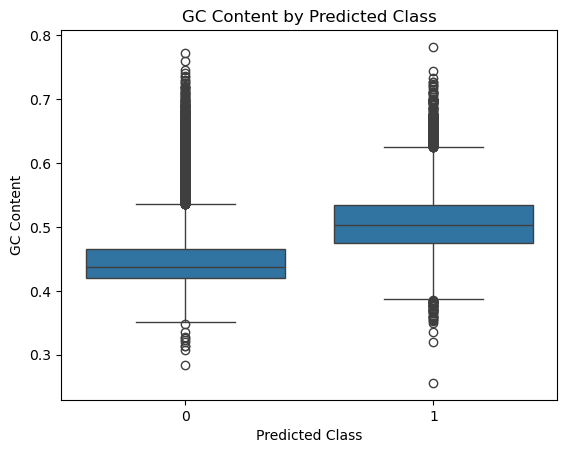

In [20]:
import seaborn as sns

# Box plot for GC content by predicted class
sns.boxplot(x='predicted_class', y='gc_content', data=predictions_df)
plt.title("GC Content by Predicted Class")
plt.xlabel("Predicted Class")
plt.ylabel("GC Content")
plt.show()
